# Birdsong Classification Model
by Beck, Carly, River, and Solomon

## Part 0. Importing Packages

In [1]:
## clean up imports after :) ##
# don't forget 'pip install -r requirements.txt'


# the usual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import torch
from collections import Counter

In [2]:
# tensorflow and tings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.densenet import preprocess_input

In [3]:
# sklearn tings
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

In [ ]:
## Carly's spectrogram work B)

# Locate spectrogram folder
folder_path = 'spectrograms'

# Initialize lists
images = []
labels = []

# Get the list of all subfolders, each representing a bird type
class_names = os.listdir(folder_path)

# Create a list of class names based off the directory names (bird types)
class_names = os.listdir(folder_path)
class_names.remove('.DS_Store') # Not a bird type, but somehow a folder in there, so we remove this from the class names
# print(class_names)

['Geothlypis trichas_Common Yellowthroat', 'Mniotilta varia_Black-and-white Warbler', 'Protonotaria citrea_Prothonotary Warbler', 'Seiurus aurocapilla_Ovenbird', 'Setophaga aestiva_American Yellow Warbler', 'Setophaga caerulescens_Black-throated Blue Warbler', 'Setophaga cerulea_Cerulean Warbler', 'Setophaga citrina_Hooded Warbler', 'Setophaga coronata_Myrtle Warbler', 'Setophaga discolor_Prairie Warbler', 'Setophaga dominica_Yellow-throated Warbler', 'Setophaga fusca_Blackburnian Warbler', 'Setophaga magnolia_Magnolia Warbler', 'Setophaga pensylvanica_Chestnut-sided Warbler', 'Setophaga pinus_Pine Warbler', 'Setophaga ruticilla_American Redstart', 'Setophaga tigrina_Cape May Warbler', 'Setophaga virens_Black-throated Green Warbler', 'Vermivora chrysoptera_Golden-winged Warbler', 'Vermivora cyanoptera_Blue-winged Warbler']


In [ ]:
## Carly's spectrogram work B)

# Load images and their corresponding labels
for class_index, class_name in enumerate(class_names):    

    class_folder = os.path.join(folder_path, class_name)
    # print(class_folder)
    
    image_files = os.listdir(class_folder)
    # print(image_files)
    
    for image_file in image_files:
        image_path = os.path.join(class_folder, image_file)
        
        # image = imread(image_path)
        
        # Load the image, and resize it to 224x224 pixels
        image = load_img(image_path, target_size=(224, 224))
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # Reshape data for the model to fit a Conv2D layer (our input layer)
        image = image.reshape((
            1,                  # batch size (we are predicting this many images at a time)
            image.shape[0],     # height
            image.shape[1],     # width
            image.shape[2]      # number of channels (1 for grayscale, 3 for RGB, 4 for RGBA, etc)
            ))
           
        # Append the image data and its label
        images.append(image)
        labels.append(class_name)  # Use the bird name as the label
        
# Convert the lists of images and labels to numpy arrays
images = np.vstack(images)
labels = np.array(labels)   

# Encode the labels as integers (CNNs don't like strings)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

## Part 1. Splitting and Visualizing Our Data
Here, we should:
- check class distribution of the full dataset
- split the data into training, validation, and testing sets
- check the class distribution of the training and validation sets

In [33]:
### this is a class distribution plotting function I used for text classification - Beck ###

def plot_class_distribution(y, title, x_label='Class', y_label='Count', ax=None, y_max_override=None):
    # Dynamically set y_max based on the current input data
    y_max = y_max_override if y_max_override else max(Counter(y).values()) * 1.2

    sns.countplot(x=y, palette='Accent', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_label, size=12, color='grey')
    ax.set_ylabel(y_label, size=12, color='grey')
    ax.grid()
    plt.grid(False)

    # Set y-axis limit
    ax.set_ylim(0, y_max)

    # Add percentage text on top of the bars (if we have space)
    # for p in ax.patches:
    #     height = p.get_height()
    #     ax.text(p.get_x() + p.get_width()/2, height + (y_max * 0.025), 
    #             f'{height/len(y):.2%}', ha='center', color='black', fontsize=10)
        
        
# if we don't want to use a function, we can use the code directly like this:

C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_21028\1841686463.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Accent', ax=ax)


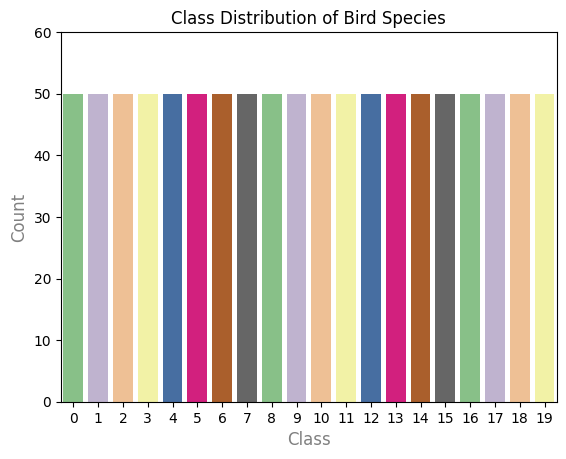

In [34]:
# plot the class distribution of the whole dataset
fig, ax = plt.subplots()
plot_class_distribution(labels_encoded, 'Class Distribution of Bird Species', ax=ax)
plt.show()


In [35]:
# split the whole dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)



C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_21028\1841686463.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Accent', ax=ax)
C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_21028\1841686463.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Accent', ax=ax)


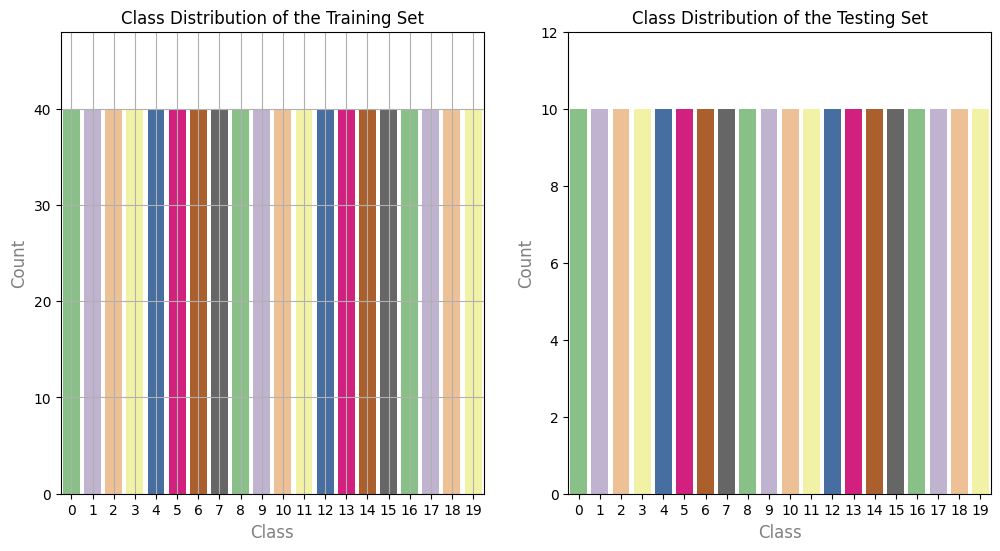

In [36]:
# plot the distribution of our subsets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_class_distribution(y_train, 'Class Distribution of the Training Set', ax=ax1)
plot_class_distribution(y_test, 'Class Distribution of the Testing Set', ax=ax2)


## Part 2. Developing the Model
Here, we should decide on and explain our CNN architecture.

In [ ]:
# define our model (Nielsen's convolutional neural network from week 4 hw)
# what's our input shape? what's our output shape?
# some of the extra layers are commented out; we should aim to overfit our code to the testing before we start adding layers back in

model = Sequential([
        Conv2D(filters=20, kernel_size=(5,5), strides=(1, 1), input_shape=[28,28,1], padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        # Conv2D(filters=40, kernel_size=(5,5), strides=(1, 1), padding='valid', activation='relu'),
        # MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        # Dense(1000, activation='relu'),
        # Dropout(0.5),
        # Dense(1000, activation='relu'),
        # Dropout(0.5),
        Dense(10, activation='softmax')
        ],
        )

model.summary()


In [ ]:
# compile the model

model.compile(optimizer=SGD(learning_rate=0.03), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=6, batch_size=32, validation_split=0.1)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

## Part 3. Training the Model

In [ ]:
# train the model on the training set

In [ ]:
# evaluate the model on the test set (copied from other code - Beck)

hist = model.history.history    # rename training history for better quality of life

# plot of accuracy during training
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot of loss during training
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# present more evaluation metrics (copied from other code - Beck)

y_test_pred_prob = model.predict(X_test)    # get the model's predictions for the test data (in probabilities)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)    # convert the predictions to class labels

# calculate and print simpler evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print('Final Evaluation Metrics (Normalized)')
print(f'Accuracy: {accuracy*100:.0f}')
print(f'Precision: {precision*100:.0f}')
print(f'Recall: {recall*100:.0f}')
print(f'F1 Score: {f1*100:.0f}')

# create and plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true') * 100  # normalize the confusion matrix and multiply by 100 to show percentages
cm_labels = ['Hate Speech', 'Offensive Language', 'Neither']
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
display.plot(cmap='Blues', values_format='.2f') # add color map and format to 2 decimal places
plt.title("Normalized Confusion Matrix (Percentages)")
plt.grid(False)
plt.show()
